# E08 인물사진을 만들어 보자

In [95]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

PATH = '/content/drive/MyDrive/Github/AIFFEL/E08'

In [125]:
img_path = PATH + '/images/jungin2.jpeg'
cat_path = PATH + '/images/cat2.jpeg'
background_img_orig = '/images/스폰지밥.jpeg'
img_orig = cv2.imread(img_path) 
cat_orig = cv2.imread(cat_path) 
print (img_orig.shape)
print (cat_orig.shape)

(728, 720, 3)
(592, 1059, 3)


In [97]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        #모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize
        resized_image = cv2.resize(img_orig, target_size)
        #OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input

    #실제로 세그멘테이션하는 함수    
    def run(self, image):#전처리된 이미지를 입력값으로 사용
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [98]:
# define model and download & load pretrained weight
#구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드하고
#PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전
#https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = PATH + '/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

# DeepLabModel 을 초기화
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/Github/AIFFEL/E08/models
model loaded successfully!


## 1. 사람

In [115]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(592, 1059, 3) (286, 513, 3) 9


- img_orig 의 크기는 800x450
- img_resized 의 크기는 513x288
- HWC(Height, Width, Channel) 
- (물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 seg_map.max() 20

- background를 제외하면 20개의 클래스가 존재
- person : 15

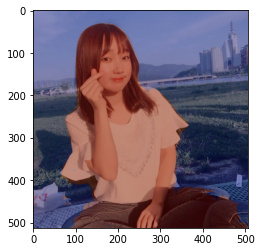

In [101]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)# 색 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

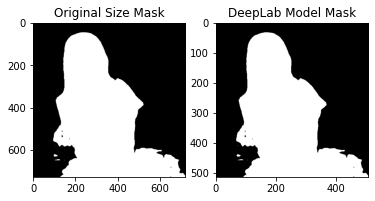

In [102]:
#DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

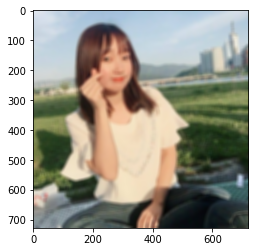

In [103]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

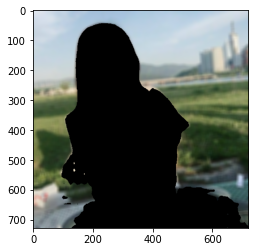

In [104]:
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
#bitwise_not 함수를 이용하면 이미지가 반전:배경은 255 사람은 0
img_bg_mask = cv2.bitwise_not(img_mask_color) 
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

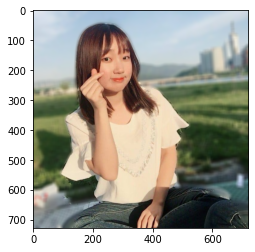

In [105]:
#배경 영상과 사람 영상을 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 고양이

In [117]:
cat_resized, seg_map = MODEL.run(cat_orig)
print (cat_orig.shape, cat_resized.shape, seg_map.max())

(592, 1059, 3) (286, 513, 3) 9


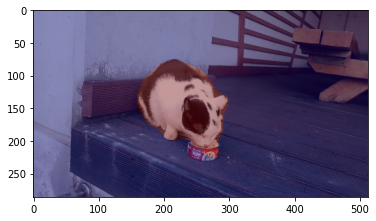

In [118]:
cat_show = cat_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출
cat_mask = seg_map * (255/seg_map.max()) # 255 normalization
cat_mask = cat_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)# 색 적용
cat_show = cv2.addWeighted(cat_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

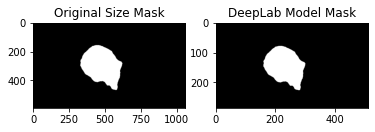

In [119]:
#DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력
cat_mask_up = cv2.resize(cat_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

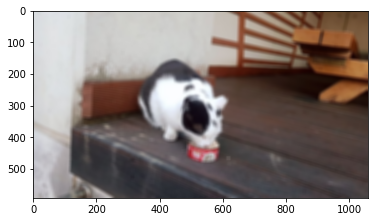

In [120]:
cat_orig_blur = cv2.blur(cat_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(cat_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

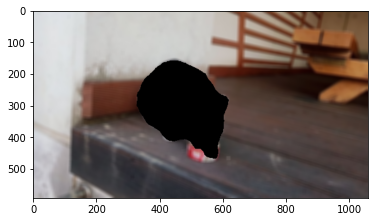

In [121]:
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
cat_mask_color = cv2.cvtColor(cat_mask_up, cv2.COLOR_GRAY2BGR)
#bitwise_not 함수를 이용하면 이미지가 반전:배경은 255 사람은 0
cat_bg_mask = cv2.bitwise_not(cat_mask_color) 
cat_bg_blur = cv2.bitwise_and(cat_orig_blur, cat_bg_mask)
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

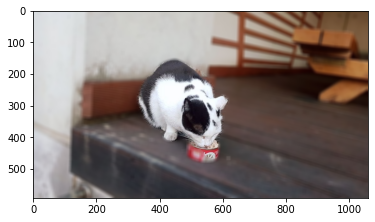

In [122]:
#배경 영상과 사람 영상을 합치기
cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 3. 크로마키

In [126]:
cat_resized = cv2.resize(
    cat_orig, (background_img_orig.shape[1], cat_orig.shape[0]))
background_img_resized = cv2.resize(
    background_img_orig, (background_img_orig.shape[1], cat_orig.shape[0]))
cat_img_mask_resized = cv2.resize(
    cat_img_mask_color, (background_img_orig.shape[1], cat_orig.shape[0]))

cat_background_concat = np.where(
    cat_img_mask_resized == 255, cat_resized, background_img_resized)

plt.imshow(cv2.cvtColor(cat_background_concat, cv2.COLOR_BGR2RGB))
plt.show()


AttributeError: ignored